## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm

from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error

In [2]:
warnings.filterwarnings('ignore')

## Считывание данных

In [3]:
df = pd.read_csv("Dataset/fields_norm.csv")
df.head(2)

,field,region,land_type,fertility_score,season,crop,crop_predecessor,crop_yearold,area,hybrid,...,yield_fact,is_anomaly_p2o5,is_anomaly_k2o,is_anomaly_ph,is_anomaly_humus,is_anomaly_yield_plan,is_anomaly_yield_fact,is_anomaly_area,count_anomaly,region_raw
0,22.47.01.001.01,Другое,пашня,NaN,2023,злаки,Пар; Яр.пшеница мягкая,NaN,306.22,Скипетр,...,2.465597,False,False,False,False,False,False,True,0,Алтай
1,22.47.01.001.02,Другое,пашня,NaN,2023,NaN,Пар; Яр.пшеница мягкая,NaN,63.16,NaN,...,NaN,False,False,False,False,True,True,False,1,Алтай


## Предобработка

In [4]:
df = df[df["crop"] == "злаки"]
df = df[~df["yield_plan"].isna()]
df = df[~df["yield_fact"].isna()]
df = df[df["count_anomaly"] == 0]
df = df[df["region"] != "Другое"]
df = df[df["is_anomaly_yield_fact"] == 0] ###
df = df.reset_index(drop=True)
df.head(2)

,field,region,land_type,fertility_score,season,crop,crop_predecessor,crop_yearold,area,hybrid,...,yield_fact,is_anomaly_p2o5,is_anomaly_k2o,is_anomaly_ph,is_anomaly_humus,is_anomaly_yield_plan,is_anomaly_yield_fact,is_anomaly_area,count_anomaly,region_raw
0,36.01.21.012.00,КурВо,пашня,3.0,2023,злаки,Подсолнечник кондит.,NaN,81.94,Вакула,...,0.000,False,False,False,False,False,False,False,0,Воронеж
1,36.01.21.013.00,КурВо,пашня,3.0,2023,злаки,Подсолнечник кондит.,NaN,157.36,Вакула,...,2.765,False,False,False,False,False,False,False,0,Воронеж


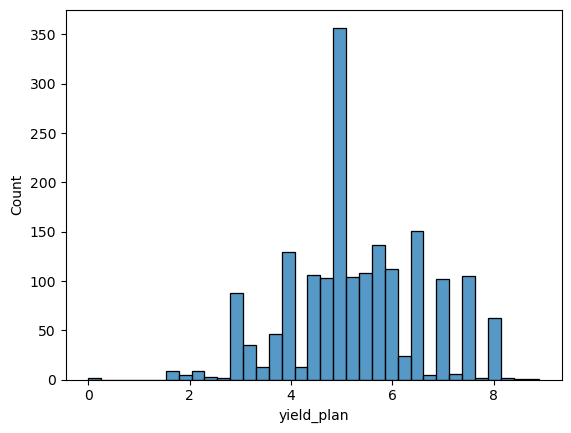

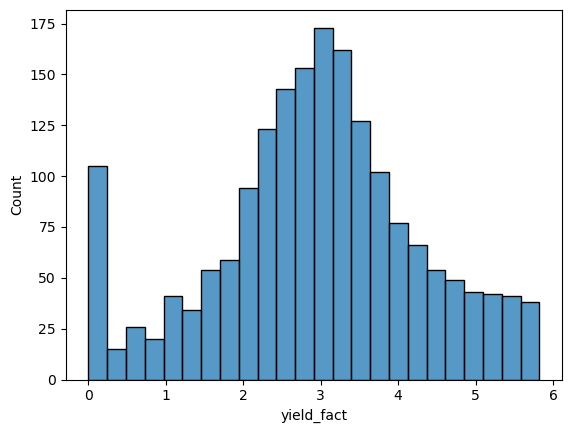

In [5]:
sns.histplot(x=df["yield_plan"])
plt.show()
sns.histplot(x=df["yield_fact"])
plt.show()

Заметим, что отсутствуют выбросы по yield_plan и перейдем к построению регрессии.

Выбросы по yield_fact отброшены.


## Создание модели

In [6]:
def db_setup(data):
    X, df_ys = data.drop(columns=["yield_fact", "yield_plan"]).values, data[["yield_plan", "yield_fact"]]
    #define our polynomial model, with whatever degree we want
    degree=2

    # PolynomialFeatures will create a new matrix consisting of all polynomial combinations
    # of the features with a degree less than or equal to the degree we just gave the model (2)
    poly_model = PolynomialFeatures(degree=degree)

    # transform out polynomial features
    X_poly = poly_model.fit_transform(X)

    df_poly = pd.DataFrame(X_poly, columns=poly_model.get_feature_names_out())

    df_poly = df_poly.drop(['x0 x3', 'x3', 'x0^2', 'x4', 'x4^2', 'x0 x2', 'x2 x4', 'x0', 'x2', 'x1', 'x1 x2', 'x1^2', 'x3 x4'], axis=1)

    df_poly = df_poly.reset_index(drop=True)
    df_ys = df_ys.reset_index(drop=True)

    df_poly = pd.concat([df_poly, df_ys], axis=1)

    return df_poly

In [7]:
df_gen = df[["season", 'region', 'p2o5', 'k2o', 'humus', 'ph', "yield_fact", "yield_plan"]]
df_gen["is_curvo"] = df["region"] == "КурВо"
df_season_setup = df_gen[['season', 'region', 'p2o5', 'k2o', 'humus', 'ph', 'is_curvo', "yield_fact", "yield_plan"]]
df_23 = df_season_setup[df_season_setup['season'] == 2023].drop(columns=["season"])
df_24 = df_season_setup[df_season_setup['season'] == 2024].drop(columns=["season"])
df_train = df_gen.drop(columns=["region", "season"])
df_23.head(2)

,region,p2o5,k2o,humus,ph,is_curvo,yield_fact,yield_plan
0,КурВо,105.5,131.5,6.35,5.55,True,0.000,5.0
1,КурВо,136.0,128.0,6.00,6.00,True,2.765,5.0


In [8]:
X, df_y_plan, y = df_train.drop(columns=["yield_fact", "yield_plan"]).values, df[["yield_plan"]], df_train["yield_fact"].values

X[0], y[0]

(array([105.5, 131.5, 6.35, 5.55, True], dtype=object), np.float64(0.0))

In [9]:
#define our polynomial model, with whatever degree we want
degree=2

# PolynomialFeatures will create a new matrix consisting of all polynomial combinations
# of the features with a degree less than or equal to the degree we just gave the model (2)
poly_model = PolynomialFeatures(degree=degree)

# transform out polynomial features
X_poly = poly_model.fit_transform(X)

df_poly = pd.DataFrame(X_poly, columns=poly_model.get_feature_names_out())

# should be in the form [1, a, b, a^2, ab, b^2]
# print(f'initial values {X[0]}\nMapped to {X_poly[0]}')
df_poly.head(2)

,1,x0,x1,x2,x3,x4,x0^2,x0 x1,x0 x2,x0 x3,...,x1^2,x1 x2,x1 x3,x1 x4,x2^2,x2 x3,x2 x4,x3^2,x3 x4,x4^2
0,1.0,105.5,131.5,6.35,5.55,1.0,11130.25,13873.25,669.925,585.525,...,17292.25,835.025,729.825,131.5,40.3225,35.2425,6.35,30.8025,5.55,1.0
1,1.0,136.0,128.0,6.00,6.00,1.0,18496.00,17408.00,816.000,816.000,...,16384.00,768.000,768.000,128.0,36.0000,36.0000,6.00,36.0000,6.00,1.0


In [10]:
# # poly_model.get_feature_names_out()
# df_poly = X
# df_poly = pd.DataFrame(X_poly)

In [11]:
df_poly.shape, df_y_plan.shape

((1841, 21), (1841, 1))

In [12]:
df_poly.columns

Index(['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3',
       'x0 x4', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x2^2', 'x2 x3', 'x2 x4',
       'x3^2', 'x3 x4', 'x4^2'],
      dtype='object')

In [13]:
df_poly_n = df_poly.drop(['x0 x3', 'x3', 'x0^2', 'x4', 'x4^2', 'x0 x2', 'x2 x4', 'x0', 'x2', 'x1', 'x1 x2', 'x1^2', 'x3 x4'], axis=1)

In [14]:
df_poly_n = df_poly_n.reset_index(drop=True)
df_y_plan = df_y_plan.reset_index(drop=True)

df_poly_n = pd.concat([df_poly_n, df_y_plan], axis=1)
df_poly_n.head(2)

,1,x0 x1,x0 x4,x1 x3,x1 x4,x2^2,x2 x3,x3^2,yield_plan
0,1.0,13873.25,105.5,729.825,131.5,40.3225,35.2425,30.8025,5.0
1,1.0,17408.00,136.0,768.000,128.0,36.0000,36.0000,36.0000,5.0


In [15]:
df_poly_n.shape, y.shape

((1841, 9), (1841,))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_poly_n, y, test_size=0.2, random_state=42)
X_train.columns

Index(['1', 'x0 x1', 'x0 x4', 'x1 x3', 'x1 x4', 'x2^2', 'x2 x3', 'x3^2',
       'yield_plan'],
      dtype='object')

In [17]:
X_train, yield_plan_train = X_train.drop(columns=["yield_plan"]), X_train["yield_plan"]
X_test, yield_plan_test = X_test.drop(columns=["yield_plan"]), X_test["yield_plan"]

In [18]:
regression_model = LinearRegression()

regression_model.fit(X_train, y_train)

y_pred = regression_model.predict(X_test)

In [19]:
y_pred_test = regression_model.predict(X_test)
y_pred_train = regression_model.predict(X_train)

In [20]:
mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_train, yield_plan_train)

(np.float64(1.0356656506767106), np.float64(2.4028069191306236))

In [21]:
mean_absolute_error(y_test, y_pred_test), mean_absolute_error(y_test, yield_plan_test)

(np.float64(0.9791831474143634), np.float64(2.2832068157428953))

In [22]:
X_test.columns

Index(['1', 'x0 x1', 'x0 x4', 'x1 x3', 'x1 x4', 'x2^2', 'x2 x3', 'x3^2'], dtype='object')

In [23]:
regression_model.coef_

array([ 0.00000000e+00,  2.08246361e-05, -2.30499196e-03, -8.28766355e-04,
        3.19233238e-03, -3.93077786e-02,  7.30781705e-02, -2.64265835e-02])

In [24]:
df_23["is_curvo"] = df_23["region"] == "КурВо"
df_23 = df_23.drop(columns=["region"])
df_23 = db_setup(df_23)
X_23, y_23 = df_23.drop(columns=["yield_fact"]), df_23["yield_fact"]
X_23, plan = X_23.drop(columns=["yield_plan"]), X_23["yield_plan"]
mean_absolute_error(y_23, regression_model.predict(X_23)), mean_absolute_error(y_23, plan)

(np.float64(1.1615035371910816), np.float64(2.310589952686102))

In [25]:
df_24["is_curvo"] = df_24["region"] == "КурВо"
df_24 = df_24.drop(columns=["region"])
df_24 = db_setup(df_24)
X_24, y_24 = df_24.drop(columns=["yield_fact"]), df_24["yield_fact"]
X_24, plan = X_24.drop(columns=["yield_plan"]), X_24["yield_plan"]
mean_absolute_error(y_24, regression_model.predict(X_24)), mean_absolute_error(y_24, plan)

(np.float64(0.8732505774002557), np.float64(2.4540134653279884))

Оптимизация статзначимости

In [26]:
a = ['x0 x3', 'x3', 'x0^2', 'x4', 'x4^2', 'x0 x2', 'x2 x4', 'x0', 'x2', 'x1', 'x1 x2', 'x1^2', 'x3 x4']
drop = []
out1 = []

for i, e in enumerate(a):
  drop.append(e)

  df_poly_n = pd.concat([df_poly, df_y_plan], axis=1)
  df_poly_n = df_poly_n.drop(drop, axis=1)

  df_poly_n.head(2)

  X_train, X_test, y_train, y_test = train_test_split(df_poly_n, y, test_size=0.2, random_state=42)
  X_train.columns

  X_train, yield_plan_train = X_train.drop(columns=["yield_plan"]), X_train["yield_plan"]
  X_test, yield_plan_test = X_test.drop(columns=["yield_plan"]), X_test["yield_plan"]

  X_train = sm.add_constant(X_train)

  regression_model = sm.OLS(y_train, X_train).fit()

  out1.append([i, regression_model.pvalues.max(), "max"])
  out1.append([i, regression_model.pvalues.median(), "median"])

out1 = pd.DataFrame(out1, columns=['Итерация', 'p-value', 'Значение'])

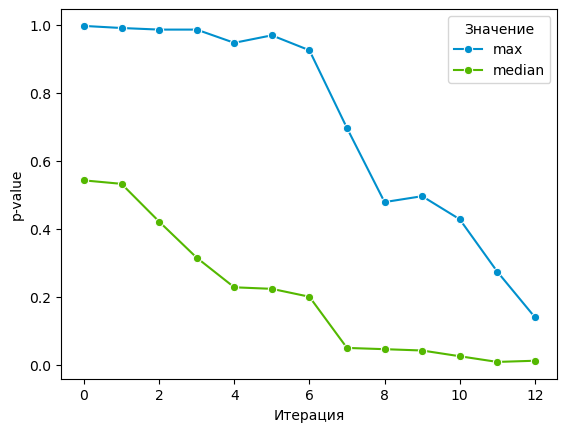

In [27]:
ar = sns.lineplot(out1, x='Итерация', y='p-value', hue='Значение', marker="o", palette={'max': "#0090CD", 'median': "#54B800"})
None